<a href="https://colab.research.google.com/github/choderalab/pinot/blob/master/scripts/adlala_spiral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# download and import

In [6]:
! wget https://raw.githubusercontent.com/choderalab/pinot/master/pinot/inference/adlala.py

--2020-04-28 16:24:44--  https://raw.githubusercontent.com/choderalab/pinot/master/pinot/inference/adlala.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6764 (6.6K) [text/plain]
Saving to: ‘adlala.py’

adlala.py           100%[===================>]   6.61K  --.-KB/s    in 0s      

2020-04-28 16:24:44 (112 MB/s) - ‘adlala.py’ saved [6764/6764]



In [0]:
! export PYTHONPATH=$PYTHONPATH:/content/

In [0]:
from adlala import AdLaLa
import torch
import numpy as np

# data

In [0]:
def twospirals(datapoints, spiralturns = 4, noise=.02, p = 0.5, a = 2):
    
    """
     Creates a two spiral planar dataset consisting of the 2D coordinates (X) of the datapoints 
     and the corresponding labels (Y).
     The user can set the number of datapoints (N), the number of turns of the spiral (default = 4) 
     and the noise level (default = 0.02).
    """
    
    N = int(datapoints/2)  
    
    # Generate a (N,1) array with samples from the uniform distribution over [0,1)
    t = np.random.rand(N,1)
    
    # Generate noise-free training data
    dx1 = a*(t**p)*np.cos(2*spiralturns*(t**p)*np.pi) 
    dx2 = a*(t**p)*np.sin(2*spiralturns*(t**p)*np.pi)
    
    X = np.vstack((np.hstack((dx1,dx2)),np.hstack((-dx1,-dx2)))) + np.random.randn( 2*N,2) * noise # Coordinates
    Y = np.hstack((np.zeros(N),np.ones(N))) # Corresponding Labels
    
    return torch.Tensor(X),torch.Tensor(Y)  # Return data + labels as torch.Tensors

In [0]:
# Prepare our data into the correct format for PyTorch's Dataloader 
class spirals(torch.utils.data.Dataset):
    
    def __init__(self,length):
        super().__init__()
        self.length = length
        self.x,self.y = twospirals(self.length)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
Ntrain = 500                # Set the number of training data points
datanew = spirals(Ntrain)    # Generate training data points
batchsize = 25               # The batch size can be set here
dataloader = torch.utils.data.DataLoader(datanew, batch_size=batchsize, shuffle = True)  # Feed the data into the dataloader.

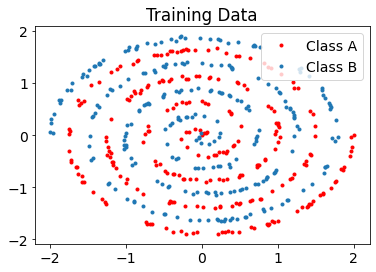

There are 500 training data points!


In [14]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
x, y = twospirals(500) 
xplot = x.detach().numpy()
yplot = y.detach().numpy()
plt.rcParams.update({'font.size': 14})
plt.title('Training Data')
plt.plot(xplot[yplot==0,0], xplot[yplot==0,1], '.', label='Class A',color='red')
plt.plot(xplot[yplot==1,0], xplot[yplot==1,1], '.', label='Class B')
plt.legend()
plt.show()
print(f'There are {x.shape[0]} training data points!')

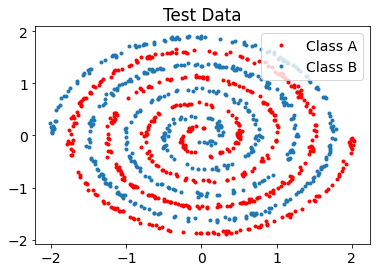

There are 1000 training data points!


In [15]:
Ntest = 1000  # Set the number of test data points
xtest,ytest = twospirals(Ntest) # Create the test data

# Visualize the test dataset
xtestplot = xtest.detach().numpy()
ytestplot = ytest.detach().numpy()
plt.rcParams.update({'font.size': 14})
plt.title('Test Data')
plt.plot(xtestplot[ytestplot==0,0], xtestplot[ytestplot==0,1], '.', label='Class A',color='red')
plt.plot(xtestplot[ytestplot==1,0], xtestplot[ytestplot==1,1], '.', label='Class B')
plt.legend()
plt.show()
print(f'There are {xtest.shape[0]} training data points!')

In [0]:
def accuracy_Nclass(out,y):
    diff = np.count_nonzero(np.round(out.squeeze())-y)
    return (1-(diff/np.size(y)))*100

In [0]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.big_pass = torch.nn.Sequential(torch.nn.Linear(2,100), 
                                      torch.nn.ReLU(),
                                      torch.nn.Linear(100, 1),
                                      torch.nn.Sigmoid()
                                     )

    def forward(self, x):
        out = self.big_pass(x)
        return out

In [48]:
from torch import nn
# Parameters
h = torch.tensor(0.25)        # Step size / learning rate
tau = torch.tensor(1e-4)     # Temperature for AdLa part (this is the first part of the partitioned system)
gamma = torch.tensor(0.1)     # Friction parameter for Langevin part
sigma = torch.tensor(0.01)    # Driving noise amplitude for Adaptive Langevin
epsilon = torch.tensor(0.05)      # Coupling coefficient for Adaptive Langevin

num_epochs = 4000   # Number of epochs

RES = [] # Will store the results (accuracy, loss, etc..) in here
total_steps = len(dataloader)  

# Initialize the neural network
NN = Net()

# The binary cross entropy loss combined with a sigmoid, is perfectly suited for a classification problem with 2 classes
criterion = nn.BCELoss()

# Use the Adam optimiser (without regularization, but this can be easily added)
optimizer = AdLaLa(
    params=[
            {
                    'params': NN.big_pass[:2].parameters(),
                    'h': h,
                    'tau': tau,
                    'sigma': sigma,
                    'epsilon': epsilon,
                    'partition': 'AdLa'
            }, 
            {
                    'params': NN.big_pass[2:].parameters(), 
                    'h': h,
                    'partition': 'La'}
            ])


# If desired one can uncomment these lines to re-initialize the weights and biases. 
#for pp in NN.parameters():
#    pp.data = torch.randn(*pp.shape)

import copy

# Training
for epoch in range(num_epochs): 

    if epoch == 1:
        net1 = copy.deepcopy(NN)
    if epoch == 50:
        net50 = copy.deepcopy(NN)
    if epoch == 1000:
        net1000 = copy.deepcopy(NN)
    if epoch == 4000:
        net4000 = copy.deepcopy(NN)


    for i,data in enumerate(dataloader):

        x,y = data   # Load in data

        def l():
            optimizer.zero_grad()
            output = NN(x)
            loss = criterion(output,y.unsqueeze(1)) # Compute the BCE loss between the neural network's output and true labels y
            loss.backward()
            return loss, output
        
        optimizer.step(l)
        
        # Evaluate how the neural network is doing and store the results
        if (epoch+1) % 10 == 0 and (i+1) % (Ntrain/batchsize) == 0:
            
            loss, output = l()

            # Compute the accuracy of the classifier on the training data
            acc = accuracy_Nclass(output.detach().numpy(),y.detach().numpy())

            # Now look at the test data: compute loss and accuracy
            outputtest = NN(xtest)
            loss_test = criterion(outputtest,ytest.unsqueeze(1))
            acc_test = accuracy_Nclass(outputtest.detach().numpy(),ytest.detach().numpy())

            # Store values
            RES += [ [epoch , loss.item(), acc,loss_test.item(),acc_test] ]

            # Print the results every 100 epochs 
            if (epoch+1) % 100 == 0:
                print(f'epoch {epoch}/{num_epochs}, step {i+1}/{total_steps}, with test loss = {loss_test.item()}')
                print("training accuracy",acc,"% and test accuracy",acc_test,"%")

RESAdLaLa = np.vstack(RES)

epoch 99/4000, step 20/20, with test loss = 0.633488118648529
training accuracy 64.0 % and test accuracy 58.099999999999994 %
epoch 199/4000, step 20/20, with test loss = 0.5771824717521667
training accuracy 88.0 % and test accuracy 63.7 %
epoch 299/4000, step 20/20, with test loss = 0.5630549788475037
training accuracy 72.0 % and test accuracy 66.5 %
epoch 399/4000, step 20/20, with test loss = 0.5199485421180725
training accuracy 76.0 % and test accuracy 71.0 %
epoch 499/4000, step 20/20, with test loss = 0.5072630047798157
training accuracy 76.0 % and test accuracy 70.39999999999999 %
epoch 599/4000, step 20/20, with test loss = 0.47411561012268066
training accuracy 92.0 % and test accuracy 75.6 %
epoch 699/4000, step 20/20, with test loss = 0.4439770579338074
training accuracy 80.0 % and test accuracy 76.7 %
epoch 799/4000, step 20/20, with test loss = 0.4254533052444458
training accuracy 84.0 % and test accuracy 79.89999999999999 %
epoch 899/4000, step 20/20, with test loss = 0.40

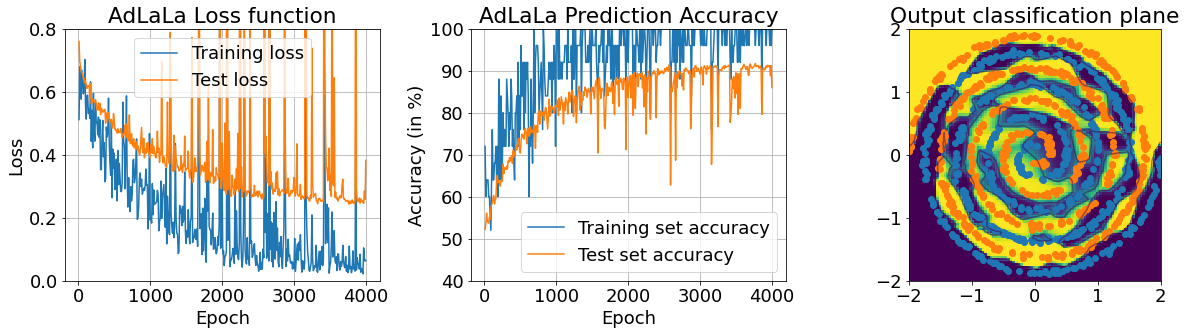

With hyperparameter settings:
Stepize h = 0.25
gamma = 0.1
sigma = 0.01
epsilon = 0.05


In [49]:
plt.figure(figsize=[17,5]) # Increase the size of the plots
plt.rcParams.update({'font.size': 18}) # Increase the size of the text in the plots

# Plot the training and test loss
plt.subplot(1,3,1)
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,1],label='Training loss')
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,3],label='Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.ylim([0,0.8])
plt.title('AdLaLa Loss function')
plt.tight_layout()

# Plot the accuracy of the classifier on the training and test dataset
plt.subplot(1,3,2)
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,2],label='Training set accuracy')
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,4],label='Test set accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (in %)')
plt.title('AdLaLa Prediction Accuracy')
plt.grid()
plt.ylim([40,100])
plt.tight_layout()

# Plot the classification plane for the current state of the neural network NN
plt.subplot(1,3,3)
xx = np.linspace(-2,2,100)
X,Y = np.meshgrid(xx,xx)
Z = np.vstack([X.reshape(-1),Y.reshape(-1)])
out = NN(torch.tensor(Z.T).float())

out=out.reshape(100,100)
plt.pcolor(xx,xx,out.data)
plt.contour(xx,xx,out.data,[0.5],alpha=0.5)
plt.axis('square')

kk1 = ytest.reshape(-1)==0
kk2 = ytest.reshape(-1)==1
plt.scatter(xtest[kk1,0],xtest[kk1,1])
plt.scatter(xtest[kk2,0],xtest[kk2,1])
plt.title('Output classification plane')
plt.tight_layout()
plt.show()

print("With hyperparameter settings:")
print("Stepize h = %g" %h)
# print("tau1 = %i, tau2 = %i" %(tau))
print("gamma = %g" %gamma)
print("sigma = %g" %sigma)
print("epsilon = %g" %epsilon)
# print("N1 = %i" %N1)



In [50]:
net1.parameters

<bound method Module.parameters of Net(
  (big_pass): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes c

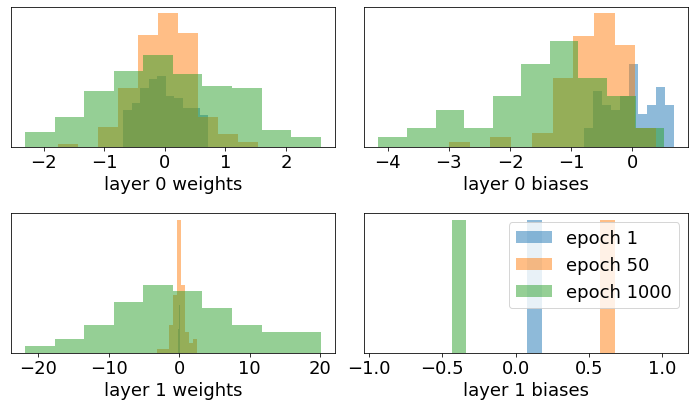

In [57]:
plt.figure(figsize=(10, 6))

for net, name in zip([net1, net50, net1000], ['epoch 1', 'epoch 50', 'epoch 1000']):
    
    ax0 = plt.subplot(221)
    ax0.hist(list(net.big_pass[0].parameters())[0].flatten().detach().numpy(), alpha=0.5, label=name)
    ax0.set_yticks([])
    ax0.set_xlabel('layer 0 weights')

    ax1 = plt.subplot(222)
    ax1.hist(list(net.big_pass[0].parameters())[1].flatten().detach().numpy(), alpha=0.5, label=name)
    ax1.set_yticks([])
    ax1.set_xlabel('layer 0 biases')


    ax2 = plt.subplot(223)
    ax2.hist(list(net.big_pass[2].parameters())[0].flatten().detach().numpy(), alpha=0.5, label=name)
    ax2.set_yticks([])
    ax2.set_xlabel('layer 1 weights')

    ax3 = plt.subplot(224)
    ax3.hist(list(net.big_pass[2].parameters())[1].flatten().detach().numpy(), alpha=0.5, label=name)
    ax3.set_yticks([])
    ax3.set_xlabel('layer 1 biases')

plt.legend()
plt.tight_layout()